In [ ]:
import pickle
from pprint import pprint

# Open the file where you stored the pickled data
with open('file_name', 'rb') as file:
    # Load the pickled data
    data = pickle.load(file)

from qiskit_ibm_runtime import QiskitRuntimeService

# Import the token if needed

service = QiskitRuntimeService(channel="ibm_quantum", token="d0883d422ddc598015c0ed32a0420d8cb99a335069b3b7e5fc26dcd6bdffa74c0918e80a16b1b45ec68b40f87cc331e14f55b42b2797f3154d6e507fbe3bd559")

In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

#Note: data must be formatted as ['type_of_gate_defect']['layer_num']['Us']['2x2x2x2 Matrix']
#and ['type_of_gate_defect']['layer_num']['acts_on'][array = [qubit1, qubit2]]

def buildCircuit(data, num_qubits, name):
    circuit = QuantumCircuit(num_qubits)
    for i in range(1, len(data[name]) + 1):
        string = 'layer_' + str(i)
        for j in range(len(data[name][string]['Us'])):
            matrix = data[name][string]['Us'][j]
            matrix = matrix.reshape(4,4)
            gate = UnitaryGate(matrix)
            array = []
            array = [ data[name][string]['acts_on'][j][0], data[name][string]['acts_on'][j][1] ]
            circuit.append(gate, array)

    circuit = circuit.reverse_bits()
    return circuit







In [12]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSydneyV2
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
import matplotlib.pyplot as plt
import numpy as np

#Creates the data array for observables (X_0 * X_i)
def runGraphOb1(circuit, num_qubit):
    L = num_qubit
    ob_1 = [0]*L
    #Create the observables 
    for i in range (1,L):
        String =  ['I'] * L
        String[0] = 'X'
        String[i] = 'X'
        String = ''.join(String)
        ob_1[i-1] = SparsePauliOp(String)
    
    fake = FakeSydneyV2()
    result_1 = [0]*L
    array_1 = np.array([])

    for i in range (0,L -1):
        pm = generate_preset_pass_manager(backend=fake, optimization_level=1)
        isa_circuit = pm.run(circuit)
        isa_observable = ob_1[i].apply_layout(isa_circuit.layout)
        estimator = Estimator(backend=fake)
        job = estimator.run([(isa_circuit, isa_observable)])
        result_1[i] = job.result()
        array_1 = np.append(array_1,result_1[i][0].data.evs)
    return array_1
                


In [13]:
#Creates the data array for observables (X_{L/2-i-1} * X_{L/2+i})
def runGraphOb2(circuit, num_qubit):
    L = num_qubit
    ob_1 = [0]*L
    #Create the obserables
    for i in range (0,int(L/2)):
        String =  ['I'] * L
        String[int((L/2) - i - 1)] = 'X'
        String[int((L/2) + i)] = 'X'
        String = ''.join(String)
        ob_1[i] = SparsePauliOp(String)
    
    fake = FakeSydneyV2()
    result_1 = [0]*L
    array_1 = np.array([])

    for i in range (0,int(L/2)):
        pm = generate_preset_pass_manager(backend=fake, optimization_level=1)
        isa_circuit = pm.run(circuit)
        isa_observable = ob_1[i].apply_layout(isa_circuit.layout)
        estimator = Estimator(backend=fake)
        job = estimator.run([(isa_circuit, isa_observable)])
        result_1[i] = job.result()
        array_1 = np.append(array_1,result_1[i][0].data.evs)
    return array_1

    # Create data arrays

                
    

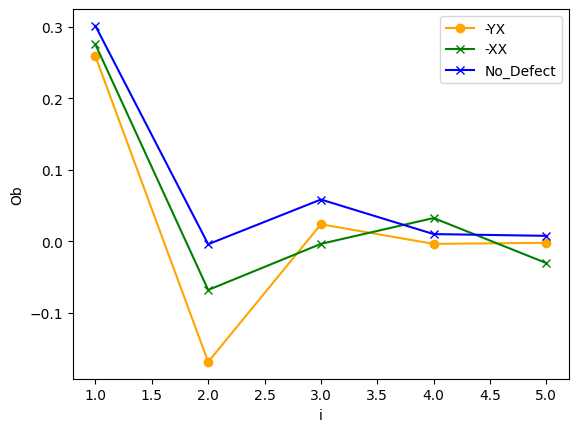

In [14]:
#Example Graphs
circuit = buildCircuit(data, 6, '-YX')

circuit.draw('mpl')

Ob1array_1 = runGraphOb1(circuit, 6)

circuit = buildCircuit(data, 6, '-XX')

circuit.draw('mpl')

Ob1array_2 = runGraphOb1(circuit, 6)


circuit = buildCircuit(data, 6, 'No_Defect')

circuit.draw('mpl')

Ob1array_3 = runGraphOb1(circuit, 6)



x = np.array([  1, 2, 3, 4, 5])

# Create the plot
plt.plot(x, Ob1array_1, label='-YX', color='orange', marker='o')
plt.plot(x, Ob1array_2, label='-XX', color='g', marker='x')
plt.plot(x, Ob1array_3, label='No_Defect', color='b', marker='x')

# Add labels and a title
plt.xlabel('i')
plt.ylabel('Ob')

# Add a legend
plt.legend()

# Show the plot
plt.show()

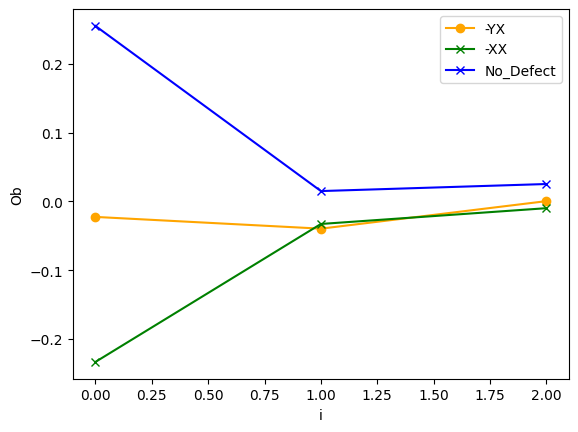

In [15]:
#Example Graphs
circuit = buildCircuit(data, 6, '-YX')

circuit.draw('mpl')

Ob1array_1 = runGraphOb2(circuit, 6)

circuit = buildCircuit(data, 6, '-XX')

circuit.draw('mpl')

Ob1array_2 = runGraphOb2(circuit, 6)


circuit = buildCircuit(data, 6, 'No_Defect')

circuit.draw('mpl')

Ob1array_3 = runGraphOb2(circuit, 6)



x = np.array([0,  1, 2])

# Create the plot
plt.plot(x, Ob1array_1, label='-YX', color='orange', marker='o')
plt.plot(x, Ob1array_2, label='-XX', color='g', marker='x')
plt.plot(x, Ob1array_3, label='No_Defect', color='b', marker='x')

# Add labels and a title
plt.xlabel('i')
plt.ylabel('Ob')

# Add a legend
plt.legend()

# Show the plot
plt.show()